# Testing different parameters for calculating elastic energy in RuvB cycle

In [1]:
import tools.load as load
import tools.spatial as spatial
import tools.sequence as seq
import tools.elastic as elastic

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator
from matplotlib.animation import FuncAnimation
from matplotlib import rcParams
from matplotlib import cm
from matplotlib import animation

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA

import warnings
import string
import time
from os import listdir as ls
from numba import jit

import pymol2
from pymol import stored

#print(rcParams.keys())

WIDTH = 3+3/8
TICK_SIZE = 6
FONT_SIZE = 8
LEGEND_SIZE = 6
TITLE_SIZE = 8

plt.rc("font", size = FONT_SIZE)
plt.rc("figure", titlesize = TITLE_SIZE)
plt.rc("xtick", labelsize = TICK_SIZE)
plt.rc("ytick", labelsize = TICK_SIZE)
plt.rc("axes", titlesize = TITLE_SIZE, labelsize = FONT_SIZE)
plt.rc("legend", fontsize = LEGEND_SIZE, frameon = False)

axis_Eel = "Elastic energy, $E_{\\rm el}$ $(kT)$"
axis_Eel_short = "El. energy, $E_{\\rm el}$ $(kT)$"

## Loading

We begin by loading the polypeptides of all the structures

In [2]:
# Input
s_names = ['s0-At2', 's1t2', 's2t2', 's3t2', 's4t2', 's5t2']

# Set a vector to describe the chains names
chain_names = list(load.char_range('A','F'))[::-1]

# Compute
s_pps = []
for name in s_names:
    structure = load.single_structure(name, chain_ids=chain_names)
    s_pps.append(structure)

n = range(len(s_pps)-1)

## Structure labeling and visualization

In [3]:
states_names = ['s' + str(i+1) for i in n]
state_chain_names = []
state_chain_names_short = []
for name in chain_names:
    for i in n:
        state_chain_names.append(name + str(i+1))
        if i == 0:
            state_chain_names_short.append(name + str(i+1))
        else:
            state_chain_names_short.append("")

transition_names = [states_names[i] + ' > ' + states_names[(i+1)%len(n)] for i in n]

In [4]:
xyz_r, labels_r = load.coordinates_all_atoms(s_pps[0])

# Indexes of chains' atoms
chain_idx = load.chain_indices(chain_names, labels_r)
chain_colors = ["tab:red", "tab:purple", "tab:blue", "tab:green", "tab:olive", "tab:orange"]

chain_colors = chain_colors[::-1]

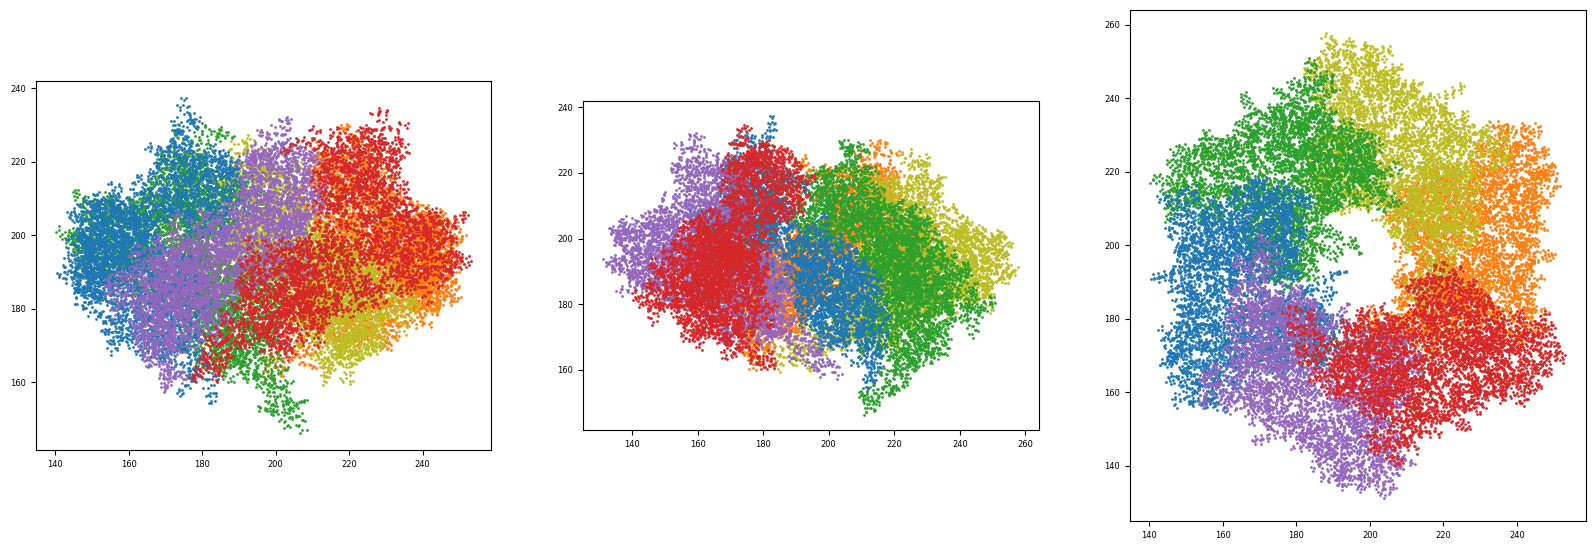

In [5]:
fig = plt.figure(figsize=(20, 10), dpi=100)
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

for idx, col in zip(chain_idx, chain_colors):
    xs, ys, zs = xyz_r[idx,0], xyz_r[idx,1], xyz_r[idx,2]

    ax1.scatter(xs, zs, s=1, color = col)
    ax2.scatter(ys, zs, s=1, color = col)
    ax3.scatter(xs, ys, s=1, color = col)

ax1.axis('scaled')
ax2.axis('scaled')
ax3.axis('scaled')
plt.show()

## Defining the set of common residues and common atoms

In [6]:
uni_ids = [None] * len([s_pps[0][3]])
indexes = []
labels_hex = []
labels_mon = []
labels_hex_at = []
labels_mon_at = []

# Compute
my_ref_seqs = seq.generate_reference([s_pps[0][3]], uni_ids)
for i in range(len(s_pps)):
    temp = dict()
    temp_at = dict()
    for j in range(len(s_pps[i])):
        temp2 = seq.aligned_dict([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        temp2_at = seq.aligned_dict_all_atoms([s_pps[i][j]], seq.align([s_pps[i][j]], my_ref_seqs))
        
        temp.update(temp2)
        temp_at.update(temp2_at)
        
        labels_mon.append(temp2)
        labels_mon_at.append(temp2_at)
    labels_hex.append(temp)
    labels_hex_at.append(temp_at)

com_res = seq.common(labels_mon[0], labels_mon[2])
com_at = seq.common_multiple([labels_mon_at[i] for i in range(6)])

## Getting protein volumes

In [7]:
vol_dir = "data/volume/"
files = np.array(ls(vol_dir))

c = 0

Vvdw, Vvoid = np.zeros(36), np.zeros(36)

for name in s_names:
    str_files = [file for file in files if name in file]
    for chain in chain_names:
        str_ch_file = [file for file in str_files if "_" + chain in file][0]
        with open(vol_dir + str_ch_file, "r") as f:
            line = f.readlines()[8].split(" ")
            line = np.array(line)
            line = line[line != '']
            
            Vvdw[c] = float(line[3].replace(",", "."))*1e-30
            Vvoid[c] = float(line[2].replace(",", "."))*1e-30
        c+=1
        
V = Vvdw + Vvoid

V_r = np.array([V[i] / V[i%6] for i in range(6, 36)])
Vvdw_r = np.array([Vvdw[i] / Vvdw[i%6] for i in range(6, 36)])
Vvoid_r = np.array([Vvoid[i] / Vvoid[i%6] for i in range(6, 36)])

V = V[6:]
Vvdw = Vvdw[6:]
Vvoid = Vvoid[6:]

## Test 1 - Backbone atoms - Varying radius

In [18]:
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates_backbone(s_pps[i], com_at, labels_hex_at[i])
    xyz.append(t1)
    labels.append(t2)

chain_idx = load.chain_indices(chain_names, labels[0])

## Volume estimation of protomers

In [19]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0])

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 3696 	v = 7.606192911651942e-26 	vf = 0.5759103600740639
O: n = 1848 	v = 2.718449940635405e-26 	vf = 0.20583010480267117
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 1848 	v = 2.882608551687326e-26 	vf = 0.2182595351232384


# Elasticity calculations

In [20]:
warnings.filterwarnings('ignore')

kT = 1.380649e-23*300
lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
time1 = time.time()
E_list = []

radii = np.arange(6, 12)
for r in radii:
    F = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
    weights = elastic.intersect_nbhood_weights(xyz, parameters=[r])
    
    # Calculating Deformation gradient
    for i in n:    
        structure_0 = labels[0][0][0][0]
        structure_i = labels[i+1][0][0][0]

        D, A = elastic.intermediate_matrixes(weights, xyz[0], xyz[i+1])
        F[i,:,:,:] = elastic.deformation_gradient(D, A)
    
    # Calculating Strain energy density function
    stretches = []
    for i in n:
        gam_l, gam_n = elastic.lagrange_strain(F[i])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)

    stretches = np.abs(stretches)**0.5
    a = np.sum((stretches**2-1)/2, axis = 2)**2
    b = np.sum(((stretches**2-1)/2)**2, axis = 2)

    psi = lame_frst/2 * a + lame_scnd * b

    # Calculating Elastic energy
    E2 = np.zeros(psi.shape)

    c = 0
    for i in range(5):
        for j, idx in zip(range(6), chain_idx):
            E2[i, idx] = Vvdw[c] * v[idx] * psi[i, idx] / np.sum(v[idx])

            c += 1

    E_list.append(E2/kT)
    print("Calculated for radius", r)
        

time1 = time.time() - time1
print("Time:", time1)

Calculated for radius 6
Calculated for radius 7
Calculated for radius 8
Calculated for radius 9
Calculated for radius 10
Calculated for radius 11
Time: 74.67885494232178


## Residue-wise energy calculation

In [21]:
# Subset the structure in domains
domain_names = ["$Head$", "$Small$", "$Large$", "$\\beta -hairpin$"]
domain_short = ["$H$", "$S$", "$L$", "$\\beta h$"]
domain_idx = [[],[],[],[]]
domain_colors = ["#97ebdb", "#00c2c7", "#0086ad", "#005582"][::-1]
domain_ranges = [range(253, 333),
                 range(182, 253), 
                 np.concatenate([range(0, 129), range(152, 182)]), 
                 range(129, 152)]


#labels_list = [i for i in labels_hex[0]]
labels_list = [i[0] for i in labels[0]]
for i in range(len(labels_list)):
    for j in range(len(domain_ranges)):
        if labels_list[i][3][1] in domain_ranges[j]:
            domain_idx[j].append(i) 

domain_aa_res = [[],[],[],[]]
domain_aa_col = [[],[],[],[]]
domain_aa_idx = [[],[],[],[]]

c=0
sequence = s_pps[0][0][0].get_sequence()
for aa in s_pps[0][0][0]:
    for j in range(len(domain_ranges)):
        if aa.get_id()[1] in domain_ranges[j]:
            domain_aa_res[j].append(sequence[c])
            domain_aa_idx[j].append(aa.get_id()[1])
            domain_aa_col[j].append(domain_colors[j])
            
    c+=1

def unlist(l):
    ul = []
    for i in l:
        ul += i
    return ul

residues_code = unlist(domain_aa_res)
residues_domain_col = unlist(domain_aa_col)
residues_idx = unlist(domain_aa_idx)

residues_code = [x for _, x in sorted(zip(residues_idx, residues_code))]
residues_domain_col = [x for _, x in sorted(zip(residues_idx, residues_domain_col))]
residues_idx.sort()

In [22]:
# nans (residues that were excluded in the process of sequence alignment)
non_nans = np.unique([labels[0][i][0][3][1] for i in range(xyz[0].shape[0])])
non_nans = set(non_nans)
all_res = set(residues_idx)
nans = all_res.difference(non_nans)

In [23]:
# removing nans
residues_code = [residues_code[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_domain_col = [residues_domain_col[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_idx = [residues_idx[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]

In [24]:
E_resh = []

for e, E in enumerate(E_list):
    residues_energy = np.zeros((len(residues_idx), len(chain_names), len(s_names)-1))

    for i in range(len(labels[0])):
        for k in range(len(s_names)-1):
            resi = labels[0][i][0][3][1]
            chain = labels[0][i][0][2]
            i_ = residues_idx.index(resi)
            j_ = chain_names.index(chain)

            residues_energy[i_, j_, k] += E[k, i]

    residues_energy[residues_energy == 0] = np.nan
    residues_energy_resh = residues_energy.reshape((len(residues_idx), len(chain_names) * (len(s_names)-1)))
    if e == 3:
        main_text_E_resh = residues_energy_resh
    E_resh.append(residues_energy_resh)

## Summary statistics per residue

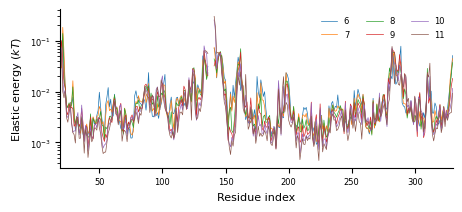

In [16]:
fig = plt.figure(figsize=(WIDTH*1.5, 2.1), dpi=100)

ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")

for i in range(len(radii)):
    ax.plot(residues_idx[:118], 
            np.mean(E_resh[i], axis = 1)[:118], 
            color = "C" + str(i), 
            lw = .5,
            label = radii[i])
    
    ax.plot(residues_idx[118:], 
            np.mean(E_resh[i], axis = 1)[118:], 
            color = "C" + str(i), 
            lw = .5)

ax.legend(ncol = 3)
ax.set_ylabel("Elastic energy ($kT$)")
ax.set_xlabel("Residue index")
ax.set_xlim(19, 330)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Global energy calculations

0.9726175558481868
0.9835091431634712
0.9947522195329246
0.974708345524624
0.9538708804887837


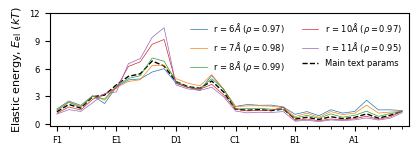

In [17]:
fig = plt.figure(figsize=(WIDTH*1.375, 1.5), dpi=100)

ax = fig.add_subplot(1, 1, 1)

for i in [0, 1, 2, 4, 5]:
    corr = np.corrcoef(np.sum(E_resh[i], axis = 0), np.sum(main_text_E_resh, axis = 0))[0,1]
    print(corr)
    
    ax.plot(np.sum(E_resh[i], axis = 0), 
            label = "r = " + str(radii[i]) + "$\AA$ $(\\rho = " + str(np.round(corr, 2)) + ")$", 
            lw = .5)
    
ax.plot(np.sum(main_text_E_resh, axis = 0), 
        lw = 1, color = "black", 
        label = "Main text params",
        linestyle = "dashed",
        zorder = -1)

ax.legend(ncol = 2, fontsize = 6)
ax.set_ylabel(axis_Eel)

ax.set_xticklabels(state_chain_names_short)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])
ax.set_yticks([0, 3, 6, 9, 12])

plt.show()

## Test 2 - Alpha Carbons - Varying radius

In [18]:
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates(s_pps[i], com_res, labels_hex[i])
    xyz.append(t1)
    labels.append(t2)

chain_idx = load.chain_indices(chain_names, labels[0])

## Volume estimation of protomers

In [19]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0])

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 1848 	v = 3.803096455826109e-26 	vf = 0.9999999999999891
O: n = 0 	v = 0 	vf = 0.0
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 0 	v = 0 	vf = 0.0


# Elasticity calculations

In [20]:
warnings.filterwarnings('ignore')

kT = 1.380649e-23*300
lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
time1 = time.time()
E_list = []

radii = np.arange(9, 12)
for r in radii:
    F = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
    weights = elastic.intersect_nbhood_weights(xyz, parameters=[r])
    
    # Calculating Deformation gradient
    for i in n:    
        structure_0 = labels[0][0][0][0]
        structure_i = labels[i+1][0][0][0]

        D, A = elastic.intermediate_matrixes(weights, xyz[0], xyz[i+1])
        F[i,:,:,:] = elastic.deformation_gradient(D, A)
    
    # Calculating Strain energy density function
    stretches = []
    for i in n:
        gam_l, gam_n = elastic.lagrange_strain(F[i])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)

    stretches = np.abs(stretches)**0.5
    a = np.sum((stretches**2-1)/2, axis = 2)**2
    b = np.sum(((stretches**2-1)/2)**2, axis = 2)

    psi = lame_frst/2 * a + lame_scnd * b

    # Calculating Elastic energy
    E2 = np.zeros(psi.shape)

    c = 0
    for i in range(5):
        for j, idx in zip(range(6), chain_idx):
            E2[i, idx] = Vvdw[c] * v[idx] * psi[i, idx] / np.sum(v[idx])

            c += 1
            
    E_list.append(E2/kT)
    print("Calculated for radius", r)
        

time1 = time.time() - time1
print("Time:", time1)

Calculated for radius 9
Calculated for radius 10
Calculated for radius 11
Time: 6.069117307662964


## Residue-wise energy calculation

In [21]:
# Subset the structure in domains
domain_names = ["$Head$", "$Small$", "$Large$", "$\\beta -hairpin$"]
domain_short = ["$H$", "$S$", "$L$", "$\\beta h$"]
domain_idx = [[],[],[],[]]
domain_colors = ["#97ebdb", "#00c2c7", "#0086ad", "#005582"][::-1]
domain_ranges = [range(253, 333),
                 range(182, 253), 
                 np.concatenate([range(0, 129), range(152, 182)]), 
                 range(129, 152)]


#labels_list = [i for i in labels_hex[0]]
labels_list = [i[0] for i in labels[0]]
for i in range(len(labels_list)):
    for j in range(len(domain_ranges)):
        if labels_list[i][3][1] in domain_ranges[j]:
            domain_idx[j].append(i) 

domain_aa_res = [[],[],[],[]]
domain_aa_col = [[],[],[],[]]
domain_aa_idx = [[],[],[],[]]

c=0
sequence = s_pps[0][0][0].get_sequence()
for aa in s_pps[0][0][0]:
    for j in range(len(domain_ranges)):
        if aa.get_id()[1] in domain_ranges[j]:
            domain_aa_res[j].append(sequence[c])
            domain_aa_idx[j].append(aa.get_id()[1])
            domain_aa_col[j].append(domain_colors[j])
            
    c+=1

def unlist(l):
    ul = []
    for i in l:
        ul += i
    return ul

residues_code = unlist(domain_aa_res)
residues_domain_col = unlist(domain_aa_col)
residues_idx = unlist(domain_aa_idx)

residues_code = [x for _, x in sorted(zip(residues_idx, residues_code))]
residues_domain_col = [x for _, x in sorted(zip(residues_idx, residues_domain_col))]
residues_idx.sort()

In [22]:
# nans (residues that were excluded in the process of sequence alignment)
non_nans = np.unique([labels[0][i][0][3][1] for i in range(xyz[0].shape[0])])
non_nans = set(non_nans)
all_res = set(residues_idx)
nans = all_res.difference(non_nans)

In [23]:
# removing nans
residues_code = [residues_code[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_domain_col = [residues_domain_col[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_idx = [residues_idx[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]

In [24]:
E_resh = []
for E in E_list:
    residues_energy = np.zeros((len(residues_idx), len(chain_names), len(s_names)-1))

    for i in range(len(labels[0])):
        for k in range(len(s_names)-1):
            resi = labels[0][i][0][3][1]
            chain = labels[0][i][0][2]
            i_ = residues_idx.index(resi)
            j_ = chain_names.index(chain)

            residues_energy[i_, j_, k] += E[k, i]

    residues_energy[residues_energy == 0] = np.nan
    residues_energy_resh = residues_energy.reshape((len(residues_idx), len(chain_names) * (len(s_names)-1)))
    E_resh.append(residues_energy_resh)

## Summary statistics per residue

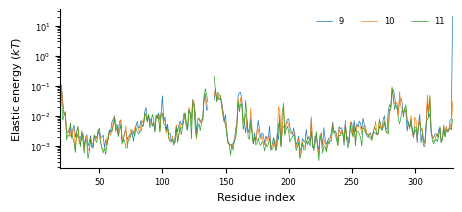

In [25]:
fig = plt.figure(figsize=(WIDTH*1.5, 2.1), dpi=100)

ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")

for i in range(len(radii)):
    ax.plot(residues_idx[:118], 
            np.mean(E_resh[i], axis = 1)[:118], 
            color = "C" + str(i), 
            lw = .5,
            label = radii[i])
    
    ax.plot(residues_idx[118:], 
            np.mean(E_resh[i], axis = 1)[118:], 
            color = "C" + str(i), 
            lw = .5)

ax.legend(ncol = 3,)
ax.set_ylabel("Elastic energy ($kT$)")
ax.set_xlabel("Residue index")
ax.set_xlim(19, 330)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Global energy calculations

-0.19204436461757665
0.9952361928809621
0.9816366377883854


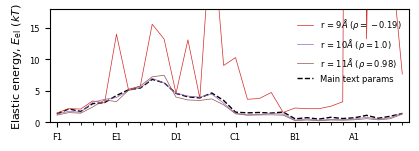

In [26]:
fig = plt.figure(figsize=(WIDTH*1.375, 1.5), dpi=100)

ax = fig.add_subplot(1, 1, 1)

for i in range(len(radii)):
    corr = np.corrcoef(np.sum(E_resh[i], axis = 0), np.sum(main_text_E_resh, axis = 0))[0,1]
    print(corr)
    ax.plot(np.sum(E_resh[i], axis = 0), 
            label = "r = " + str(radii[i]) + "$\AA$ $(\\rho = " + str(np.round(corr, 2)) + ")$", 
            lw = .5, color = "C" + str(i + 3))
    
ax.plot(np.sum(main_text_E_resh, axis = 0), 
        lw = 1, color = "black", 
        label = "Main text params",
        linestyle = "dashed",
        zorder = -1)

ax.set_ylim(0, 18)
ax.legend(ncol = 1, fontsize = 6)
ax.set_ylabel(axis_Eel)

ax.set_xticklabels(state_chain_names_short)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])

plt.show()

## Test 3 - All atoms - Varying radius

In [9]:
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates_all_atoms(s_pps[i], com_at, labels_hex_at[i])
    xyz.append(t1)
    labels.append(t2)

chain_idx = load.chain_indices(chain_names, labels[0])

## Volume estimation of protomers

In [10]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0])

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 9258 	v = 1.9052525426431308e-25 	vf = 0.5041204552952958
O: n = 2796 	v = 4.112979455636893e-26 	vf = 0.10882741418202846
S: n = 96 	v = 2.3451863495341712e-27 	vf = 0.0062052477759161045
H: n = 14610 	v = 1.0575053261329108e-25 	vf = 0.27981070989557477
N: n = 2448 	v = 3.8185204191181315e-26 	vf = 0.10103617285137947


# Elasticity calculations

In [ ]:
warnings.filterwarnings('ignore')

kT = 1.380649e-23*300
lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
time1 = time.time()
E_list = []

radii = np.arange(6, 12)
for r in radii:
    F = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
    weights = elastic.intersect_nbhood_weights(xyz, parameters=[r])
    
    # Calculating Deformation gradient
    for i in n:    
        structure_0 = labels[0][0][0][0]
        structure_i = labels[i+1][0][0][0]

        D, A = elastic.intermediate_matrixes(weights, xyz[0], xyz[i+1])
        F[i,:,:,:] = elastic.deformation_gradient(D, A)
    
    # Calculating Strain energy density function
    stretches = []
    for i in n:
        gam_l, gam_n = elastic.lagrange_strain(F[i])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)

    stretches = np.abs(stretches)**0.5
    a = np.sum((stretches**2-1)/2, axis = 2)**2
    b = np.sum(((stretches**2-1)/2)**2, axis = 2)

    psi = lame_frst/2 * a + lame_scnd * b

    # Calculating Elastic energy
    E2 = np.zeros(psi.shape)

    c = 0
    for i in range(5):
        for j, idx in zip(range(6), chain_idx):
            E2[i, idx] = Vvdw[c] * v[idx] * psi[i, idx] / np.sum(v[idx])

            c += 1
            
    E_list.append(E2/kT)
    print("Calculated for radius", r)
        

time1 = time.time() - time1
print("Time:", time1)

Calculated for radius 6
Calculated for radius 7
Calculated for radius 8
Calculated for radius 9


## Residue-wise energy calculation

In [39]:
# Subset the structure in domains
domain_names = ["$Head$", "$Small$", "$Large$", "$\\beta -hairpin$"]
domain_short = ["$H$", "$S$", "$L$", "$\\beta h$"]
domain_idx = [[],[],[],[]]
domain_colors = ["#97ebdb", "#00c2c7", "#0086ad", "#005582"][::-1]
domain_ranges = [range(253, 333),
                 range(182, 253), 
                 np.concatenate([range(0, 129), range(152, 182)]), 
                 range(129, 152)]


#labels_list = [i for i in labels_hex[0]]
labels_list = [i[0] for i in labels[0]]
for i in range(len(labels_list)):
    for j in range(len(domain_ranges)):
        if labels_list[i][3][1] in domain_ranges[j]:
            domain_idx[j].append(i) 

domain_aa_res = [[],[],[],[]]
domain_aa_col = [[],[],[],[]]
domain_aa_idx = [[],[],[],[]]

c=0
sequence = s_pps[0][0][0].get_sequence()
for aa in s_pps[0][0][0]:
    for j in range(len(domain_ranges)):
        if aa.get_id()[1] in domain_ranges[j]:
            domain_aa_res[j].append(sequence[c])
            domain_aa_idx[j].append(aa.get_id()[1])
            domain_aa_col[j].append(domain_colors[j])
            
    c+=1

def unlist(l):
    ul = []
    for i in l:
        ul += i
    return ul

residues_code = unlist(domain_aa_res)
residues_domain_col = unlist(domain_aa_col)
residues_idx = unlist(domain_aa_idx)

residues_code = [x for _, x in sorted(zip(residues_idx, residues_code))]
residues_domain_col = [x for _, x in sorted(zip(residues_idx, residues_domain_col))]
residues_idx.sort()

In [40]:
# nans (residues that were excluded in the process of sequence alignment)
non_nans = np.unique([labels[0][i][0][3][1] for i in range(xyz[0].shape[0])])
non_nans = set(non_nans)
all_res = set(residues_idx)
nans = all_res.difference(non_nans)

In [41]:
# removing nans
residues_code = [residues_code[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_domain_col = [residues_domain_col[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_idx = [residues_idx[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]

In [42]:
E_resh = []
for E in E_list:
    residues_energy = np.zeros((len(residues_idx), len(chain_names), len(s_names)-1))

    for i in range(len(labels[0])):
        for k in range(len(s_names)-1):
            resi = labels[0][i][0][3][1]
            chain = labels[0][i][0][2]
            i_ = residues_idx.index(resi)
            j_ = chain_names.index(chain)

            residues_energy[i_, j_, k] += E[k, i]

    residues_energy[residues_energy == 0] = np.nan
    residues_energy_resh = residues_energy.reshape((len(residues_idx), len(chain_names) * (len(s_names)-1)))
    E_resh.append(residues_energy_resh)

## Summary statistics per residue

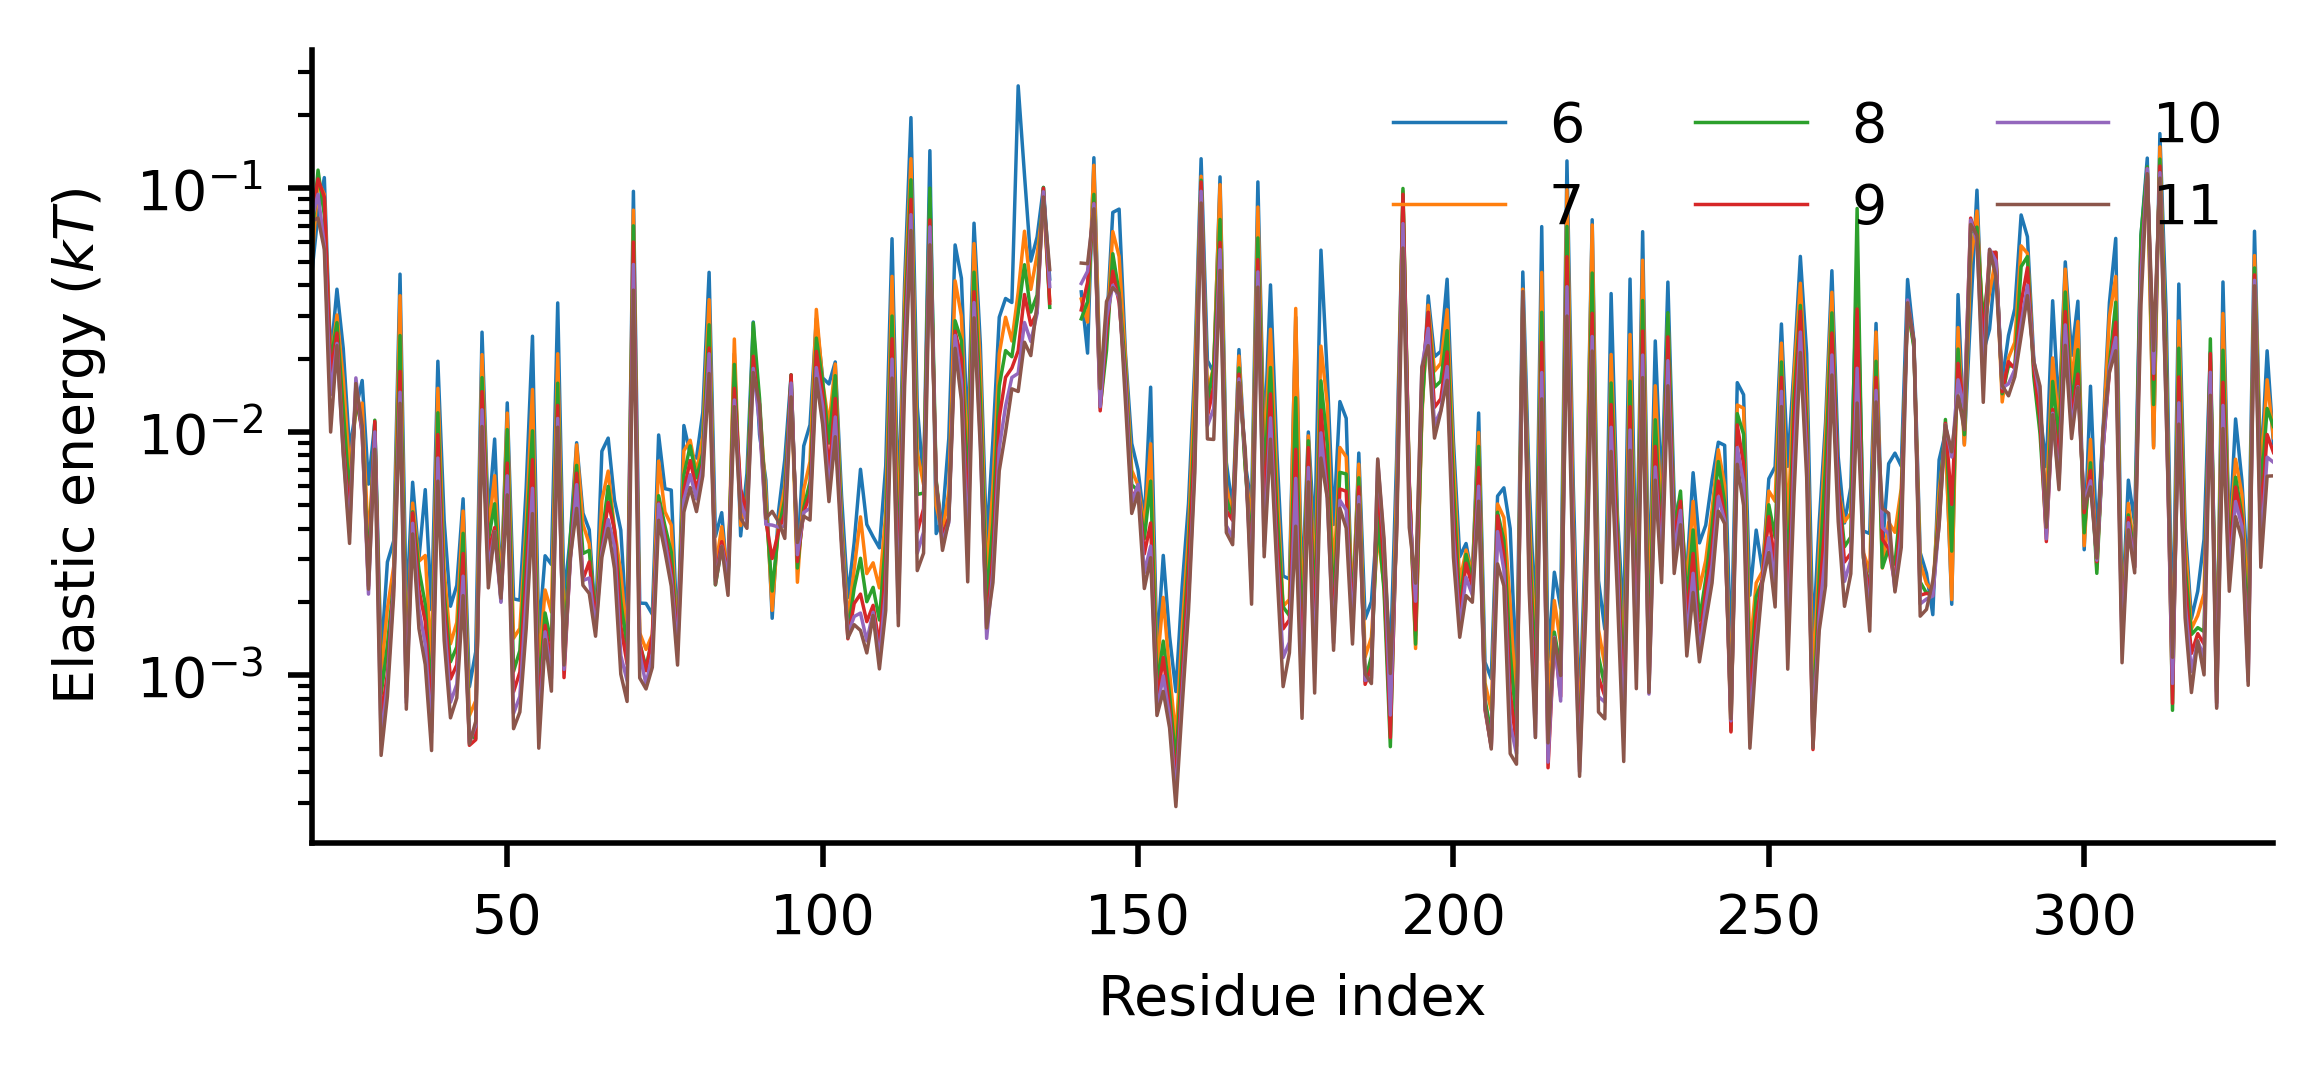

In [69]:
fig = plt.figure(figsize=(WIDTH*1.5, 2.1), dpi=100)

ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")

for i in range(len(radii)):
    ax.plot(residues_idx[:118], 
            np.mean(E_resh[i], axis = 1)[:118], 
            color = "C" + str(i), 
            lw = .5,
            label = radii[i])
    
    ax.plot(residues_idx[118:], 
            np.mean(E_resh[i], axis = 1)[118:], 
            color = "C" + str(i), 
            lw = .5)

ax.legend(ncol = 3)
ax.set_ylabel("Elastic energy ($kT$)")
ax.set_xlabel("Residue index")
ax.set_xlim(19, 330)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Global energy calculations

0.9575635086376424
0.9677111068824669
0.9690146769749579
0.9755083856723399
0.9779986716666925
0.980251846367738


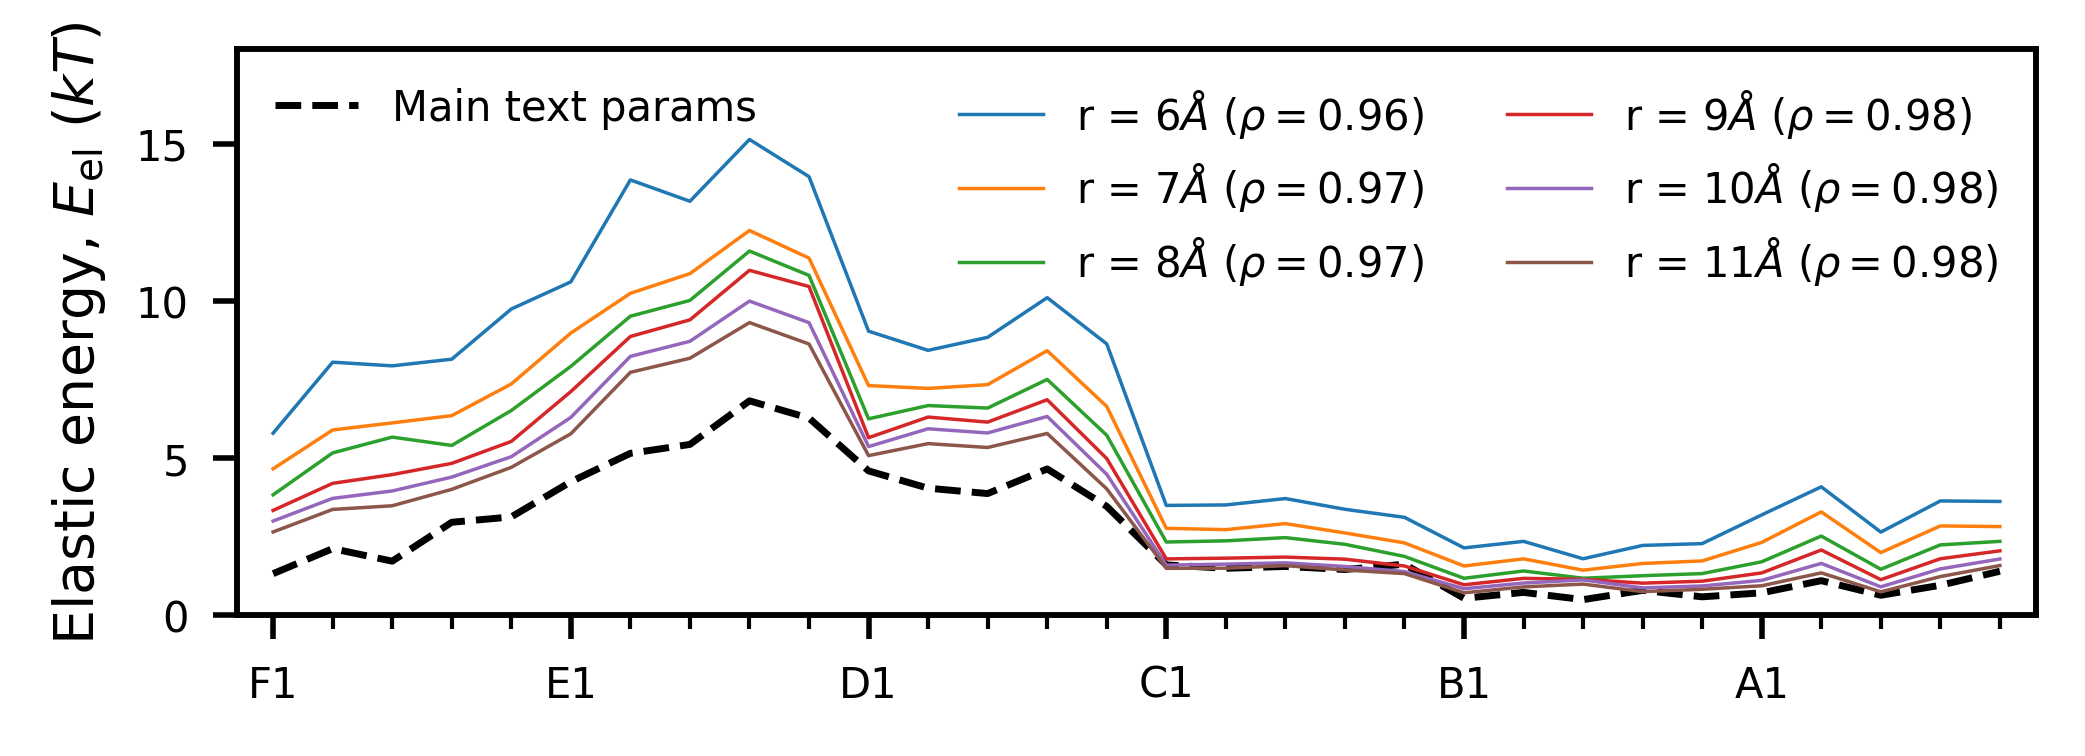

In [45]:
fig = plt.figure(figsize=(WIDTH*1.375, 1.5), dpi=100)

ax = fig.add_subplot(1, 1, 1)

for i in range(len(radii)):
    corr = np.corrcoef(np.sum(E_resh[i], axis = 0), np.sum(main_text_E_resh, axis = 0))[0,1]
    print(corr)
    ax.plot(np.sum(E_resh[i], axis = 0), 
            label = "r = " + str(radii[i]) + "$\AA$ $(\\rho = " + str(np.round(corr, 2)) + ")$", 
            lw = .5)
    
ax.plot(np.sum(main_text_E_resh, axis = 0), 
        lw = 1, color = "black", 
        linestyle = "dashed",
        zorder = -1)
ax.set_ylim(0, 18)

ax.legend(ncol = 2, fontsize = 6, alignment = "right")
ax.set_ylabel("Elastic energy ($kT$)")

ax.set_ylabel(axis_Eel)

ax.set_xticklabels(state_chain_names_short)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])

a2 = ax.twinx()
a2.set_yticks([])
a2.plot([], 
        lw = 1, color = "black", 
        label = "Main text params",
        linestyle = "dashed",
        zorder = -1)
a2.legend(ncol = 1, fontsize = 6, loc = "upper left")

plt.show()

## Test 4 - Backbone atoms - Varying method

In [25]:
xyz = []
labels = []

for i in range(len(s_pps)):
    t1, t2 = load.coordinates_backbone(s_pps[i], com_at, labels_hex_at[i])
    xyz.append(t1)
    labels.append(t2)

chain_idx = load.chain_indices(chain_names, labels[0])

## Volume estimation of protomers

In [26]:
vdw = {"C":1.7e-10, "O":1.52e-10, "S":1.8e-10, "H":1.2e-10, "N":1.55e-10}
n_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}
v_atom = {"C":0, "O":0, "S":0, "H":0, "N":0}

v = np.zeros(xyz[0].shape[0])

for i in range(len(v)):
    at = labels[0][i][1]
    
    v[i] = 4*np.pi*vdw[at]**3/3
    n_atom[at] += 1
    v_atom[at] += v[i]

for at in list(vdw.keys()):
    print(at + ": n =", n_atom[at], "\tv =", v_atom[at], "\tvf =", v_atom[at]/np.sum(v))

C: n = 3696 	v = 7.606192911651942e-26 	vf = 0.5759103600740639
O: n = 1848 	v = 2.718449940635405e-26 	vf = 0.20583010480267117
S: n = 0 	v = 0 	vf = 0.0
H: n = 0 	v = 0 	vf = 0.0
N: n = 1848 	v = 2.882608551687326e-26 	vf = 0.2182595351232384


# Elasticity calculations

In [27]:
warnings.filterwarnings('ignore')

kT = 1.380649e-23*300
lame_frst = 72976559.0446705 
lame_scnd = 37593984.96240601
time1 = time.time()
E_list = []

method = [elastic.intersect_nbhood_weights,
          elastic.avg_linear_weights_fulldata,
          elastic.avg_linear_weights_fulldata,
          elastic.intersect_nbhood_weights,
          elastic.intersect_nbhood_weights]

params = [[9.], 
          [9., 9.001], 
          [9., 9.001], 
          [9.], 
          [9.]]

coords = ["pair", 
          "all", 
          "pair", 
          "ref", 
          "cycle"]

m_label = ["Intersect, pairwise",
           "Linear, all",
           "Linear, pairwise",
           "Only reference",
           "Only cycle"]

for ms, ps, cs in zip(method, params, coords):
    F = np.zeros((len(s_pps)-1, len(xyz[0]), 3, 3))
    
    # Calculating Deformation gradient
    for i in n:    
        structure_0 = labels[0][0][0][0]
        structure_i = labels[i+1][0][0][0]
        
        if cs == "pair":
            weights = ms([xyz[0], xyz[i+1]], ps)
        elif cs == "all":
            weights = ms(xyz, ps)
        elif cs == "ref":
            weights = ms([xyz[0]], ps)
        elif cs == "cycle":
            weights = ms([xyz[i+1]], ps)

        D, A = elastic.intermediate_matrixes(weights, xyz[0], xyz[i+1])
        F[i,:,:,:] = elastic.deformation_gradient(D, A)
    
    # Calculating Strain energy density function
    stretches = []
    for i in n:
        gam_l, gam_n = elastic.lagrange_strain(F[i])
        st, st_axis = elastic.principal_stretches_from_g(gam_n)
        stretches.append(st)

    stretches = np.abs(stretches)**0.5
    a = np.sum((stretches**2-1)/2, axis = 2)**2
    b = np.sum(((stretches**2-1)/2)**2, axis = 2)

    psi = lame_frst/2 * a + lame_scnd * b

    # Calculating Elastic energy
    E2 = np.zeros(psi.shape)

    c = 0
    for i in range(5):
        for j, idx in zip(range(6), chain_idx):
            E2[i, idx] = Vvdw[c] * v[idx] * psi[i, idx] / np.sum(v[idx])

            c += 1
            
    E_list.append(E2/kT)
        

time1 = time.time() - time1
print("Time:", time1)

Time: 72.34266114234924


## Residue-wise energy calculation

In [28]:
# Subset the structure in domains
domain_names = ["$Head$", "$Small$", "$Large$", "$\\beta -hairpin$"]
domain_short = ["$H$", "$S$", "$L$", "$\\beta h$"]
domain_idx = [[],[],[],[]]
domain_colors = ["#97ebdb", "#00c2c7", "#0086ad", "#005582"][::-1]
domain_ranges = [range(253, 333),
                 range(182, 253), 
                 np.concatenate([range(0, 129), range(152, 182)]), 
                 range(129, 152)]


#labels_list = [i for i in labels_hex[0]]
labels_list = [i[0] for i in labels[0]]
for i in range(len(labels_list)):
    for j in range(len(domain_ranges)):
        if labels_list[i][3][1] in domain_ranges[j]:
            domain_idx[j].append(i) 

domain_aa_res = [[],[],[],[]]
domain_aa_col = [[],[],[],[]]
domain_aa_idx = [[],[],[],[]]

c=0
sequence = s_pps[0][0][0].get_sequence()
for aa in s_pps[0][0][0]:
    for j in range(len(domain_ranges)):
        if aa.get_id()[1] in domain_ranges[j]:
            domain_aa_res[j].append(sequence[c])
            domain_aa_idx[j].append(aa.get_id()[1])
            domain_aa_col[j].append(domain_colors[j])
            
    c+=1

def unlist(l):
    ul = []
    for i in l:
        ul += i
    return ul

residues_code = unlist(domain_aa_res)
residues_domain_col = unlist(domain_aa_col)
residues_idx = unlist(domain_aa_idx)

residues_code = [x for _, x in sorted(zip(residues_idx, residues_code))]
residues_domain_col = [x for _, x in sorted(zip(residues_idx, residues_domain_col))]
residues_idx.sort()

In [29]:
# nans (residues that were excluded in the process of sequence alignment)
non_nans = np.unique([labels[0][i][0][3][1] for i in range(xyz[0].shape[0])])
non_nans = set(non_nans)
all_res = set(residues_idx)
nans = all_res.difference(non_nans)

In [30]:
# removing nans
residues_code = [residues_code[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_domain_col = [residues_domain_col[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]
residues_idx = [residues_idx[i] for i in range(len(residues_idx)) if residues_idx[i] in non_nans]

In [31]:
E_resh = []
for E in E_list:
    residues_energy = np.zeros((len(residues_idx), len(chain_names), len(s_names)-1))

    for i in range(len(labels[0])):
        for k in range(len(s_names)-1):
            resi = labels[0][i][0][3][1]
            chain = labels[0][i][0][2]
            i_ = residues_idx.index(resi)
            j_ = chain_names.index(chain)

            residues_energy[i_, j_, k] += E[k, i]

    residues_energy[residues_energy == 0] = np.nan
    residues_energy_resh = residues_energy.reshape((len(residues_idx), len(chain_names) * (len(s_names)-1)))
    E_resh.append(residues_energy_resh)

## Summary statistics per residue

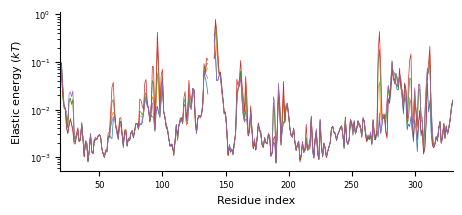

In [32]:
fig = plt.figure(figsize=(WIDTH*1.5, 2.1), dpi=100)

ax = fig.add_subplot(1, 1, 1)
ax.set_yscale("log")

for i in range(len(method)):
    ax.plot(residues_idx[:118], 
            np.mean(E_resh[i], axis = 1)[:118], 
            color = "C" + str(i), 
            lw = .5)
    
    ax.plot(residues_idx[118:], 
            np.mean(E_resh[i], axis = 1)[118:], 
            color = "C" + str(i), 
            lw = .5)

ax.set_ylabel("Elastic energy ($kT$)")
ax.set_xlabel("Residue index")
ax.set_xlim(19, 330)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## Global energy calculations

0.9727018800958609
0.9398800058982231
0.9137888609979289
0.8787204039541096
0.9641307713072425


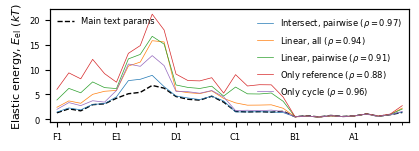

In [33]:
fig = plt.figure(figsize=(WIDTH*1.375, 1.5), dpi=100)

ax = fig.add_subplot(1, 1, 1)

for i in range(len(method)):
    corr = np.corrcoef(np.sum(E_resh[i], axis = 0), np.sum(main_text_E_resh, axis = 0))[0,1]
    print(corr)
    ax.plot(np.sum(E_resh[i], axis = 0), 
            label = m_label[i] + " $(\\rho = " + str(np.round(corr, 2)) + ")$", 
            lw = .5)
    
ax.plot(np.sum(main_text_E_resh, axis = 0), 
        lw = 1, color = "black", 
        linestyle = "dashed",
        zorder = -1)
#ax.set_ylim(0, 18)

ax.legend(ncol = 1, fontsize = 6)
ax.set_ylabel(axis_Eel)

ax.set_xticklabels(state_chain_names_short)
ax.set_xlim(-.6, 29.6)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks(range(0, 30, 5), 
              state_chain_names_short[0:30:5])

a2 = ax.twinx()
a2.set_yticks([])
a2.plot([], 
        lw = 1, color = "black", 
        label = "Main text params",
        linestyle = "dashed",
        zorder = -1)
a2.legend(ncol = 1, fontsize = 6, loc = "upper left")

plt.show()